<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>CNN
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellerklärung

CNN spielen eine zentrale Rolle in vielen Deep Learning Architekturen. Zuerst dachten wir, dass im Bereich von Deep Learning mit Textdaten die Transformerarchitekturen CNN's komplett ersetzt haben, doch unser Fachexperte meinte, dass sie immer noch eine Rolle spielen. Um dies zu untersuchen, suchten wir zuerst nach aktuellen Publikationen in diesem Bereich. Wir fanden dabei diverse Publikationen (https://link.springer.com/article/10.1007/s11042-022-13459-x, https://link.springer.com/article/10.1007/s10489-022-04221-9). In diesem Abschnitt möchte wir untersuchen, ob es möglich ist CNN zu verwenden, um eine gute Performance in einem NLP-Klassifikationstask zu erreichen. Eine "gute" Performance wird erreicht, sobald ein höherer F1-Score wie das Baseline erreicht wird.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [13]:
# All Imports
import sys
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import gensim
import gensim.downloader as api
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import keras.backend as K

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Tensorflow Version: {tf.__version__}")
print(f"Gensim Version: {gensim.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

Python Version: 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]
PyTorch Version: 1.12.1+cu116
Numpy Version: 1.23.5
Pandas Version: 1.5.0
Matplotlib Version: 3.6.2
Sklearn Version: 1.1.2
Seaborn Version: 0.12.0
Tensorflow Version: 2.11.0
Gensim Version: 4.3.2


## Einlesen des Verarbeiteten Datensatzes

In [2]:
train = pd.read_csv("./data/processed/train.csv",index_col="id")
val = pd.read_csv("./data/processed/val.csv",index_col="id")
test = pd.read_csv("./data/raw/test.csv",index_col="id")

## Pre-Processing

In [7]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train.text)

train_tokens = tokenizer.texts_to_sequences(train.text)
val_tokens = tokenizer.texts_to_sequences(val.text)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

categories = 1 

print(f"Maximal number of words of sentences {max([len(lst) for lst in train_tokens])}")

maxlen = 40

train_tokens = pad_sequences(train_tokens, padding='post', maxlen=maxlen)
val_tokens = pad_sequences(val_tokens, padding='post', maxlen=maxlen)

Maximal number of words of sentences 31


In [ ]:
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding[word]
        except:
            weight_matrix[i] = np.zeros(300)
    return weight_matrix


# get vectors in the right order
word2vec_google_news = api.load("word2vec-google-news-300")
embedding_vectors = get_weight_matrix(word2vec_google_news, tokenizer.word_index)
e = keras.layers.Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=40, trainable=True)

## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [9]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def plot_confusion_matrix(model,val_tokens=val_tokens):
    y_prediction = model.predict(val_tokens,verbose=False) > 0.5
    disp= ConfusionMatrixDisplay(confusion_matrix(val.target, y_prediction),display_labels = ["no disaster","disaster"])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()

def example_prediction(model,val_tokens=val_tokens,val_data=val):
    pd.set_option('display.max_colwidth', None)
    val_data["pred"]=model.predict(val_tokens,verbose=False) > 0.5
    return val_data.sample(15)
    

def plot_f1_score_loss(history):
    #  "f1-score"
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))
    ax1.plot(history.history['get_f1'])
    ax1.plot(history.history['val_get_f1'])
    ax1.set_title('model f1-score')
    ax1.set_ylabel('f1.score')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    # "Loss"
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.show()

## CNN Klassifikationsmodelle

### 1 Convolution und MLP

In [30]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 30, input_length=40))
model.add(keras.layers.Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
print(model.summary())

model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
history = model.fit(train_tokens, train.target, epochs=20, batch_size=512, validation_data=(val_tokens, val.target), verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 30)            586920    
                                                                 
 conv1d_3 (Conv1D)           (None, 31, 64)            19264     
                                                                 
 flatten_3 (Flatten)         (None, 1984)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1985      
                                                                 
Total params: 608,169
Trainable params: 608,169
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/40
12/12 [==============================] - 2s 59ms/step - loss: 0.6816 - get_f1: 0.0634 - val_loss: 0.6812 - val_get_f1: 0.0000e+00
Epoch 2/40
12/12 [==============================] - 0s 33ms/step - loss: 0.6594 - get_f1: 0.0732 - val_loss: 0.6524 - val_get_f1: 0.2827
Epoch 3/40
12/12 [==============================] - 0s 33ms/step - loss: 0.6074 - get_f1: 0.5496 - val_loss: 0.5961 - val_get_f1: 0.5975
Epoch 4/40
12/12 [==============================] - 0s 33ms/step - loss: 0.4960 - get_f1: 0.7378 - val_loss: 0.5218 - val_get_f1: 0.6769
Epoch 5/40
12/12 [==============================] - 0s 32ms/step - loss: 0.3413 - get_f1: 0.8376 - val_loss: 0.4655 - val_get_f1: 0.7323
Epoch 6/40
12/12 [==============================] - 0s 34ms/step - loss: 0.2163 - get_f1: 0.9072 - val_loss: 0.4915 - val_get_f1: 0.7475
Epoch 7/40
12/12 [==============================] - 0s 32ms/step - loss: 0.1350 - get_f1: 0.9440 - val_loss: 0.5424 - val_get_f1: 0.7344
Epoch 8/40
12/12 [==============

In [10]:

model = keras.Sequential()

model.add(e)
model.add(keras.layers.Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
print(model.summary())

model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
history = model.fit(train_tokens, train.target, epochs=40, batch_size=512, validation_data=(val_tokens, val.target), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 300)           5869200   
                                                                 
 conv1d (Conv1D)             (None, 31, 64)            192064    
                                                                 
 flatten (Flatten)           (None, 1984)              0         
                                                                 
 dense (Dense)               (None, 1)                 1985      
                                                                 
Total params: 6,063,249
Trainable params: 6,063,249
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
12/12 [==============================] - 2s 135ms/step - loss: 0.6352 - get_f1: 0.4469 - val_loss: 0.5808 - val_get_f1: 0.5961
Epoch 2/40
12/12 [=================

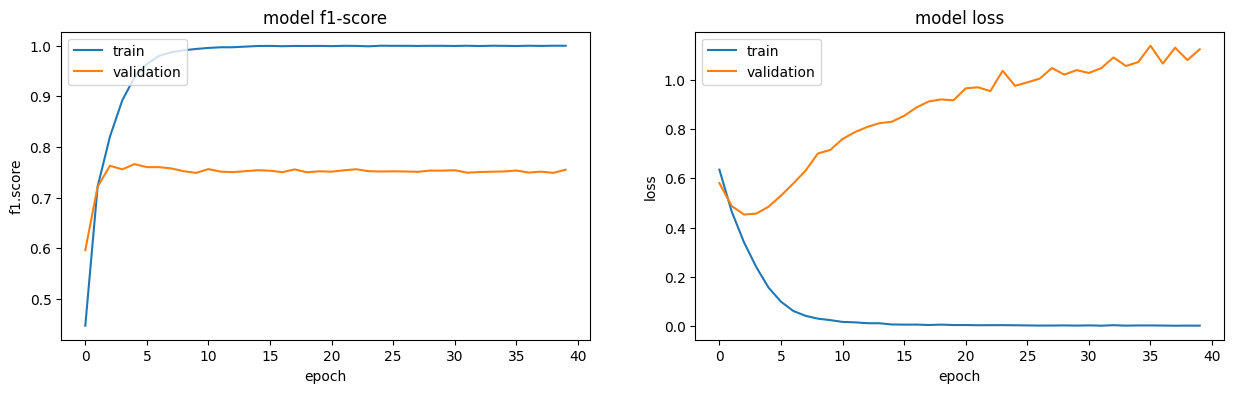

In [11]:
plot_f1_score_loss(history)

In [31]:
max(history.history['val_get_f1'])

0.7475306987762451

In [12]:
max(history.history['val_get_f1'])

0.7659265398979187

In [ ]:
def make_predictions(val_text,tokenizer=tokenizer):
    X_batch = tokenizer.texts_to_sequences(val_text)
    preds = model.predict(X_batch)
    return preds

x position of the weight

n th input to the corresponding conv layer

k th filter or kernel in the corresponding layer, respectively. 

In [42]:
model.layers[1].get_weights()

[array([[[ 0.09, -0.09, -0.1 , ..., -0.2 ,  0.04, -0.15],
         [ 0.06,  0.  ,  0.06, ...,  0.02, -0.01, -0.  ],
         [ 0.1 , -0.11, -0.03, ..., -0.12,  0.06, -0.01],
         ...,
         [ 0.19, -0.06, -0.02, ..., -0.08,  0.11, -0.12],
         [-0.18,  0.2 ,  0.09, ...,  0.05, -0.13,  0.09],
         [ 0.13, -0.1 , -0.06, ..., -0.17,  0.07, -0.05]],
 
        [[ 0.04, -0.14, -0.03, ..., -0.09, -0.07, -0.01],
         [ 0.03, -0.08,  0.14, ...,  0.02,  0.08,  0.14],
         [ 0.06, -0.08, -0.13, ..., -0.06,  0.06, -0.11],
         ...,
         [ 0.13, -0.1 , -0.12, ..., -0.17,  0.12, -0.13],
         [-0.06,  0.04,  0.04, ...,  0.09, -0.07,  0.08],
         [ 0.06,  0.06,  0.06, ..., -0.01,  0.06,  0.02]],
 
        [[-0.08, -0.07, -0.03, ..., -0.02, -0.05, -0.12],
         [-0.01, -0.  ,  0.09, ..., -0.1 ,  0.01,  0.06],
         [ 0.  , -0.06, -0.15, ..., -0.13,  0.08, -0.06],
         ...,
         [ 0.07, -0.08, -0.14, ..., -0.1 ,  0.03, -0.12],
         [-0.16,  0.15, 

In [30]:
model.weights

C:\Users\j\AppData\Local\Temp\ipykernel_11188\1955385642.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(model.weights)[:,:,1]


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [23]:
weights = [arr.flatten() for arr in np.array(model.weights[1])]

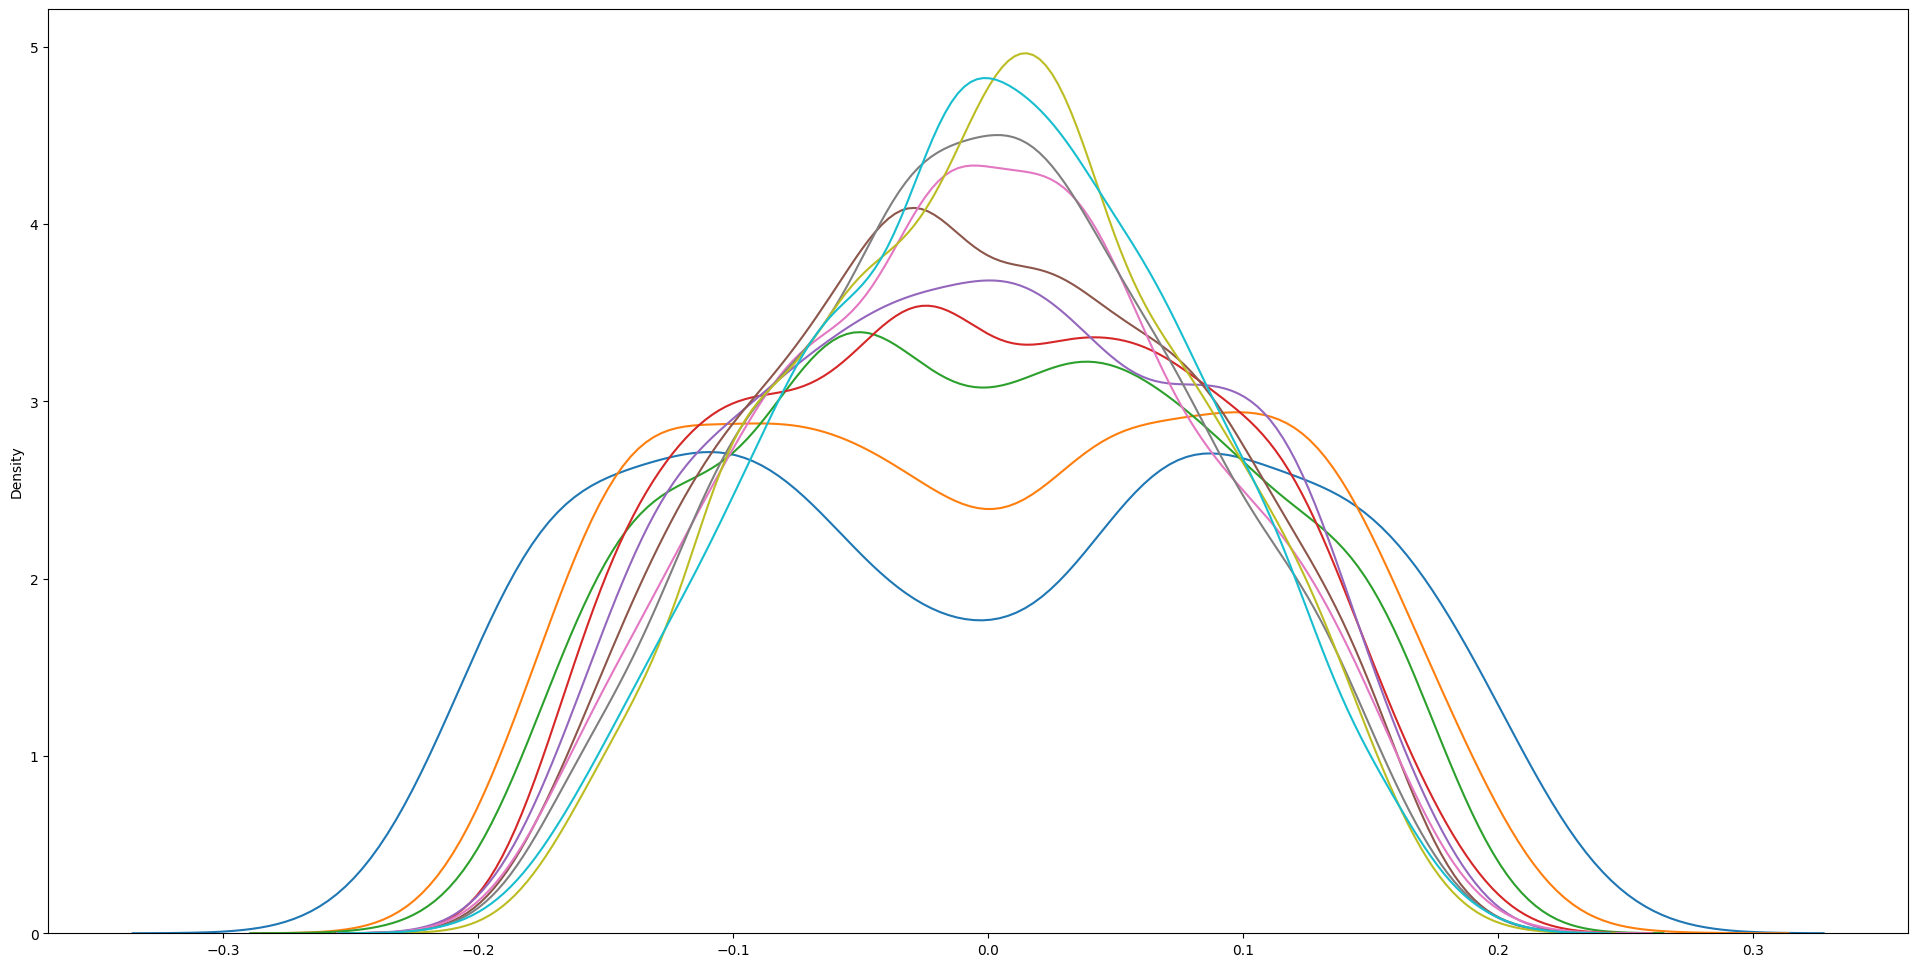

In [26]:
for x in weights:
    sns.kdeplot(x)

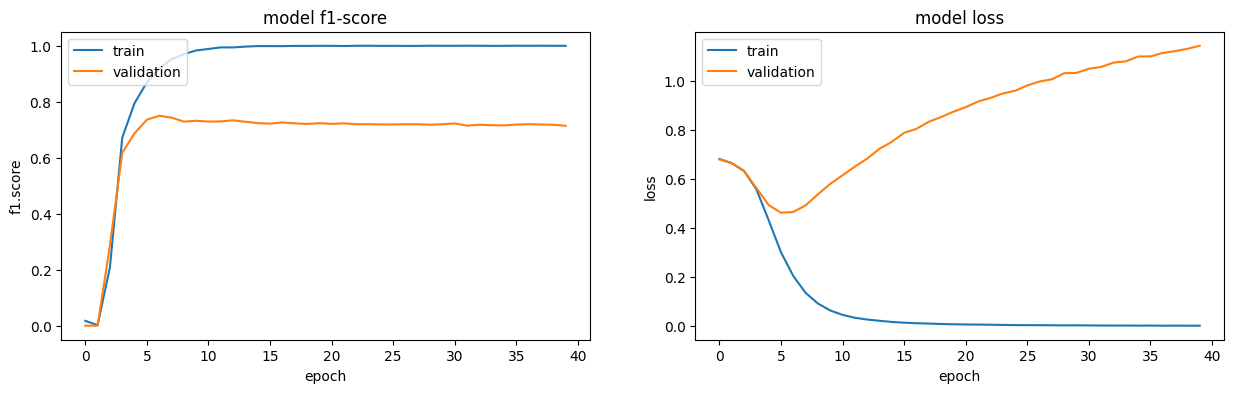

In [34]:
plot_f1_score_loss(history)

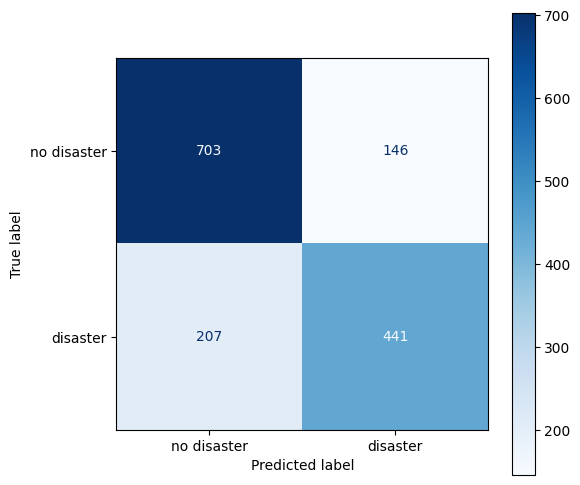

In [35]:
plot_confusion_matrix(model)

In [36]:
example_prediction(model)

,text,target,pred
id,,,
2336,SA MP. Steel and ferrochrome industry on verge of collapse. You don't even put that on list of questions to president for oral answer,0,True
5251,I liked a @YouTube video from @vgbootcamp http://t.co/7LvGCMyIyJ S@X 109 - sN | vaBengal (ZSS) Vs. SWS | Fatality (Captain Falcon),0,False
7278,3 Former Executives to Be Prosecuted in Fukushima Nuclear #Disaster.\r\n\r\nThe story: http://t.co/7uFnxxaVqs via @nytimes,1,True
3625,going to redo my nails and watch behind the scenes of desolation of smaug ayyy,1,False
8622,On Thursday at 00:25 we updated our #kml of 2D and 3D #seismic exploration vessels. #offshore #oil http://t.co/btdjGWeKqx,0,True
688,A Dayton-area org tells me it was hit by a cyber attack: http://t.co/7LhKJz0IVO,1,False
10544,*looks outside at the windstorm* niiiice,1,False
7760,California police officer pulls gun on man without any apparent provocation (VIDEO) http://t.co/Lhw4vTbHZG via @dailykos,1,True
9495,@OfficialMqm you are terrorist,0,True


### 3 convolutions, maxpooling, dropout, 2 mlp

In [38]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 30, input_length=40))
model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(20, activation="relu"))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
history = model.fit(train_tokens, train.target, epochs=40, batch_size=512, validation_data=(val_tokens, val.target), verbose=0)

In [22]:
history

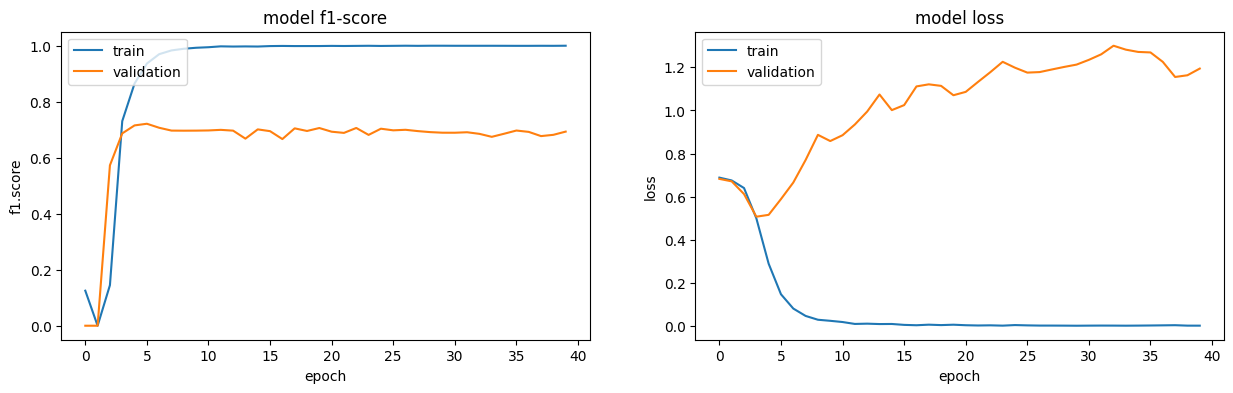

In [39]:
plot_f1_score_loss(history)

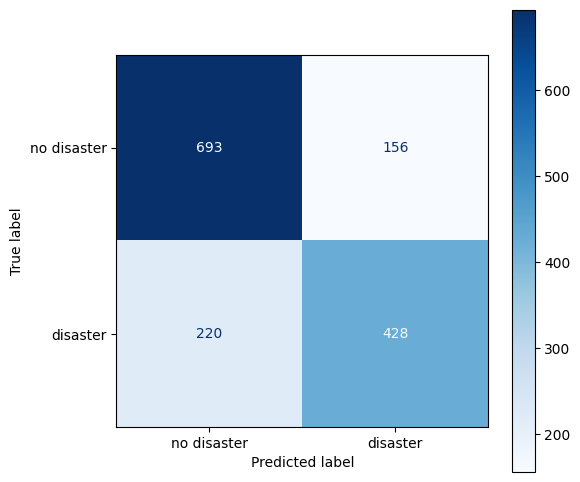

In [40]:
plot_confusion_matrix(model)

In [41]:
example_prediction(model)

,text,target,pred
id,,,
6660,#Landslide! Trump 25.5% Bush 12.5% http://t.co/xY41z0O5ei via @pollster @realdonaldtrump,0,False
2400,Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/87eFCBIczM,1,False
5540,Would've been great if Mbiwa just flattened that little rat.,0,False
8006,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/aueZxZA5ak,1,True
1559,When you get a bomb ass picture mail ????????,0,True
7426,Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/Wj0U59mPpB,0,False
6663,11:30BST traffic: A10&gt;Paris A40 Geneva A7 Mons A1 Hamburg A2&gt;Hanover A5 Karlsruhe Gotthard n/b http://t.co/yoi9tOCxiQ,1,False
8795,Thu Aug 06 2015 01:20:32 GMT+0000 (UTC)\r\n#millcityio #20150613\r\ntheramin sirens,1,True
6459,If I could I would have been by at work but got injured and we have security concerns they must settle. This is torture.,0,False


### 3 Parallel convolutions

In [66]:
def create_convnet(vocab_size,sent_length, num_classes):
    input_shape =  keras.layers.Input(shape=(sent_length,))
    emb = keras.layers.Embedding(vocab_size, 30)(input_shape)

    tower_1 =  keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu')(emb)
    #tower_1 =  keras.layers.GlobalMaxPooling1D()(tower_1)
    tower_1 = keras.layers.Flatten()(tower_1)

    tower_2 =  keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu')(emb)
    #tower_2 =  keras.layers.GlobalMaxPooling1D()(tower_2)
    tower_2 = keras.layers.Flatten()(tower_2)

    tower_3 =  keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(emb)
    #tower_3 =  keras.layers.GlobalMaxPooling1D()(tower_3)
    tower_3 = keras.layers.Flatten()(tower_3)

    merged = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)
    merged =  keras.layers.Flatten()(merged)

    out =  keras.layers.Dense(50, activation='relu')(merged)
    out =  keras.layers.Dense(num_classes, activation='sigmoid')(out)

    model = keras.Model(input_shape, out)
    return model

model = create_convnet(vocab_size,40,1)
print(model.summary())
model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
history = model.fit(train_tokens, train.target, epochs=30, batch_size=512, validation_data=(val_tokens, val.target), verbose=1)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 40, 30)       586920      ['input_12[0][0]']               
                                                                                                  
 conv1d_46 (Conv1D)             (None, 36, 256)      38656       ['embedding_23[0][0]']           
                                                                                                  
 conv1d_47 (Conv1D)             (None, 37, 128)      15488       ['embedding_23[0][0]']           
                                                                                           

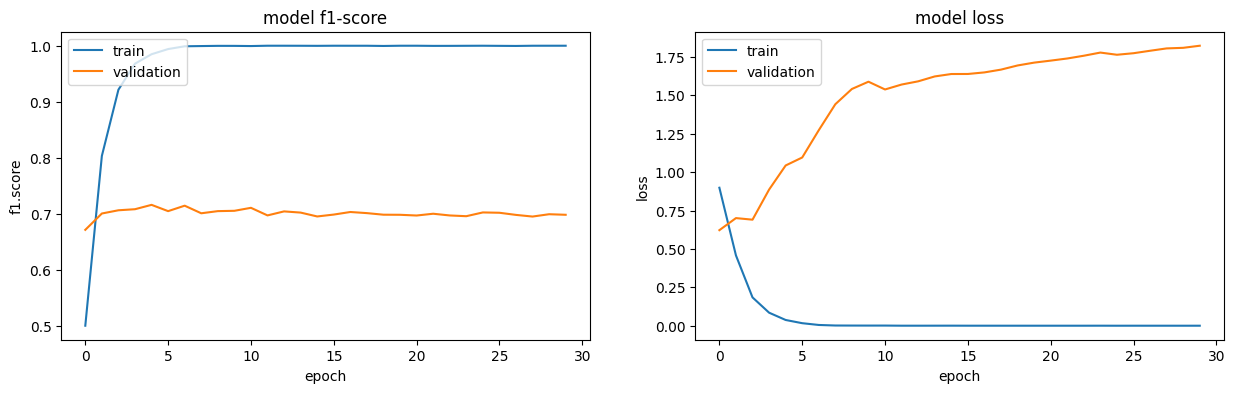

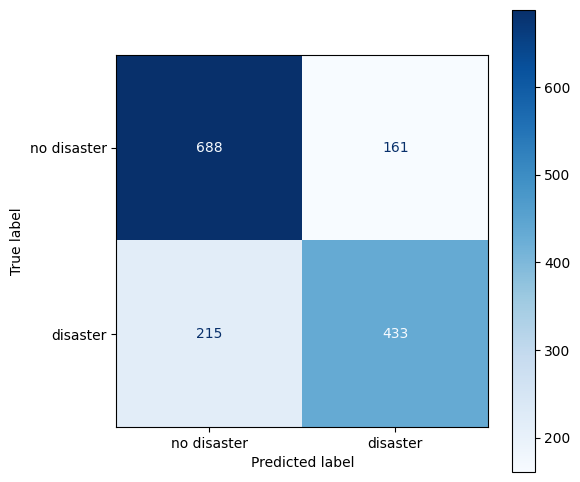

,text,target,pred
id,,,
5028,@kaputt21 Hamburg Police Chief Gregory Wickett has told 7 Eyewitness News he 'can't confirm or deny' an investigation is underway.,0,False
4614,Brooklyn locksmith: domesticate emergency mechanic services circa the clock movement!: gba http://t.co/1Q6ccFfzV6,0,True
1202,Tomorrow's Announcement VODs http://t.co/cUbze5MIZm,0,True
222,Pilot Dies In Plane Crash At Car Festival https://t.co/kQ9aE6AP2B via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest,1,True
4017,CW500: Dealing with disaster - http://t.co/jq9nJ6Gko3,1,True
3761,Truck Driver Salvages Banned Tomatoes From Destruction on #Russian Border http://t.co/7b2Wf6ovFK #news,0,True
8503,@BizzleMahomie SCREAMING,0,False
4622,The #tubestrike is because TFL workers may have trouble planning downtime. I hope none need emergency services. http://t.co/iCSFDSiFqb,0,False
10367,WWII Memories Plus Lessons of Hiroshima We Still Need Nuclear Weapons http://t.co/xbMm7ITe9q #denver #billings #rapidcity #seattle #cheyenne,1,True


In [65]:
plot_f1_score_loss(history)
plot_confusion_matrix(model)
example_prediction(model)

### Auswertung des Modells

## Evaluation
In der Evaluation beschreiben wir, welche Metrik verwendet wurde, wieso die Metrik für den Anwendungsfall passt und diskutieren die Ergebnisse der Experimente und einige Vorhersagen auf einzelnen Testsamples.

## Erkenntnisse

## Fazit